In [35]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf

import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import ConvLSTM2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.models import Model

raw_data = pd.read_csv("NYPD_Complaint_Data_Historic.csv")

C:\Users\sachin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (18,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [36]:
raw_data.shape

(7375993, 35)

In [37]:
raw_data = raw_data[["CMPLNT_FR_DT", "Latitude", "Longitude"]].dropna()

In [38]:
day_one = np.datetime64('2006-01-01')
days = (pd.to_datetime(raw_data['CMPLNT_FR_DT'], 
                 format='%m/%d/%Y', errors='coerce') - day_one).dt.days
days = days[days.isnull() == False]
days = days[days > 0]

In [39]:
rd = raw_data.copy()
rd = rd[rd['Latitude'] > rd['Latitude'].mean() - 3 * rd['Latitude'].std()]\
                [rd['Latitude'] < rd['Latitude'].mean() + 3 * rd['Latitude'].std()]
rd = rd[rd['Longitude'] > rd['Longitude'].mean() - 3 * rd['Longitude'].std()]\
                [rd['Longitude'] < rd['Longitude'].mean() + 3 * rd['Longitude'].std()]
# rd = rd.sample(frac=0.5, random_state=1)
# rd.shape

C:\Users\sachin\AppData\Local\Temp/ipykernel_14228/4123303284.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rd = rd[rd['Latitude'] > rd['Latitude'].mean() - 3 * rd['Latitude'].std()]\
C:\Users\sachin\AppData\Local\Temp/ipykernel_14228/4123303284.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rd = rd[rd['Longitude'] > rd['Longitude'].mean() - 3 * rd['Longitude'].std()]\


In [40]:
min_lat, max_lat = min(rd["Latitude"]), max(rd["Latitude"])
min_lng, max_lng = min(rd["Longitude"]), max(rd["Longitude"])

In [41]:
GRID_LNG_DIM = 100
GRID_LAT_DIM = 120
lng_step = (max_lng - min_lng) / (GRID_LNG_DIM - 1)
lat_step = (max_lat - min_lat) / (GRID_LAT_DIM - 1)
def to_grid_lat(lat):
    return (lat - min_lat) // lat_step
def to_grid_lng(lng):
    return (lng - min_lng) // lng_step

In [42]:
data = pd.DataFrame(rd["CMPLNT_FR_DT"])
data["Days"] = days
data["GridLat"] = to_grid_lat(rd['Latitude'])
data["GridLng"] = to_grid_lng(rd['Longitude'])
data = data.dropna()
data["Days"] = data["Days"].astype("int16")
data["GridLat"] = data["GridLat"].astype("int8")
data["GridLng"] = data["GridLng"].astype("int8")
# To split the validation set to the most recent crimes
data.sort_values(by=["Days"])

CMPLNT_FR_DT  Days  GridLat  GridLng
5415309   01/02/2006     1       42       36
6580278   01/02/2006     1       90       66
4230817   01/02/2006     1       41       91
6706895   01/02/2006     1       98       47
4912539   01/02/2006     1       50       74
...              ...   ...      ...      ...
739935    12/31/2020  5478      100       59
747102    12/31/2020  5478       94       53
748185    12/31/2020  5478       20       47
747101    12/31/2020  5478       49       46
743520    12/31/2020  5478       56       35

[7247072 rows x 4 columns]

In [43]:
crime_grid_n = np.zeros((max(data["Days"]) + 1, GRID_LNG_DIM + 1, GRID_LAT_DIM + 1), dtype="float32")
crime_grid_n[data["Days"], data["GridLng"], data["GridLat"]] = 1
crime_grid_n[15][30]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)

In [44]:
len(crime_grid_n[crime_grid_n == 1]) / crime_grid_n.size

0.07411722771440893

In [45]:
index = np.arange(1,31)[None, :] + np.arange(5449)[:, None]

In [46]:
x = crime_grid_n[index]

In [47]:
X = x[:, :29, :, :, None]
y = x[:, 29, :, :, None]

In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [49]:
y_train[0][1].shape

(121, 1)

In [50]:
model = Sequential()
model.add(ConvLSTM2D(1, kernel_size=(3, 3), activation='tanh', recurrent_activation='hard_sigmoid', 
                        kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',
                        kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, 
                        return_sequences=False,
                        padding='same',
                        data_format='channels_last',
                        dropout=0.0, recurrent_dropout=0.0))

model.compile(optimizer=Adam(decay=1e-4),
              loss='mean_squared_error',
              metrics=['accuracy'])

In [51]:
# Prepare model model saving directory.
# save_dir = os.path.join(os.getcwd(), 'saved_models')
# model_name = 'crime_prediction.{epoch:03d}.h5'
# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)
# filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
# checkpoint = ModelCheckpoint(filepath=filepath,
#                              monitor='val_acc',
#                              verbose=1,
#                              save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

Callbacks = callbacks = [es, lr_reducer]

model.fit(X_train, y_train,
          batch_size=120,
          epochs=10,
          validation_data=(X_test, y_test),
          shuffle=True,
          callbacks=Callbacks)

#model.summary()

Epoch 1/10
37/37 [==============================] - 380s 10s/step - loss: 0.0544 - accuracy: 0.9262 - val_loss: 0.0530 - val_accuracy: 0.9267 - lr: 0.0010
Epoch 2/10
37/37 [==============================] - 378s 10s/step - loss: 0.0522 - accuracy: 0.9274 - val_loss: 0.0514 - val_accuracy: 0.9285 - lr: 0.0010
Epoch 3/10
37/37 [==============================] - 378s 10s/step - loss: 0.0508 - accuracy: 0.9295 - val_loss: 0.0503 - val_accuracy: 0.9307 - lr: 0.0010
Epoch 4/10
37/37 [==============================] - 378s 10s/step - loss: 0.0500 - accuracy: 0.9312 - val_loss: 0.0496 - val_accuracy: 0.9319 - lr: 0.0010
Epoch 5/10
37/37 [==============================] - 377s 10s/step - loss: 0.0494 - accuracy: 0.9321 - val_loss: 0.0491 - val_accuracy: 0.9326 - lr: 0.0010
Epoch 6/10
37/37 [==============================] - 378s 10s/step - loss: 0.0489 - accuracy: 0.9327 - val_loss: 0.0487 - val_accuracy: 0.9329 - lr: 0.0010
Epoch 7/10
37/37 [==============================] - 378s 10s/step - lo

In [52]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_2 (ConvLSTM2D)  (None, 101, 121, 1)       76        
                                                                 
Total params: 76
Trainable params: 76
Non-trainable params: 0
_________________________________________________________________


In [53]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

35/35 [==============================] - 32s 903ms/step - loss: 0.0477 - accuracy: 0.9341
Test loss: 0.04765358939766884
Test accuracy: 0.9341174364089966


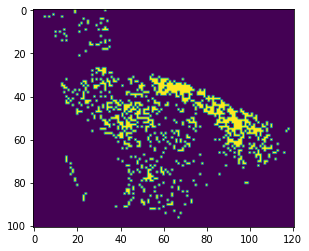

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

r = y_test[0][:,:,0]
p = np.round(model.predict(X_test[:2]), decimals=0)[0][:, :, 0]

plt.imshow(r)

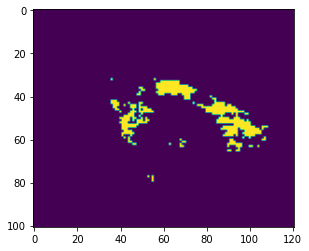

In [55]:
plt.imshow(p)